## Import des Bibliothèques

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
# Modèles linéaires
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# Modèles d'arbres
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

!pip install xgboost


# Fonction pour tester toute les algos de régression

In [23]:
def test_regression_algorithms(X, y, test_size=0.2, random_state=42, cv=5, scale_data=True, use_xgboost=False):
    """
    Teste différents algorithmes de régression et compare leurs performances.

    Paramètres:
    -----------
    X : array-like ou DataFrame
        Variables indépendantes (features)
    y : array-like ou Series
        Variable cible
    test_size : float, default=0.2
        Proportion des données pour le test
    random_state : int, default=42
        Graine aléatoire pour la reproductibilité
    cv : int, default=5
        Nombre de folds pour la validation croisée
    scale_data : bool, default=True
        Si True, standardise les données pour les modèles linéaires
    use_xgboost : bool, default=False
        Si True, inclut XGBoost (nécessite l'installation du package)

    Retourne:
    ---------
    DataFrame avec les métriques de chaque modèle
    dict avec les modèles entraînés
    StandardScaler utilisé (ou None)
    """

    # Séparation des données
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Standardisation pour les modèles linéaires
    scaler = None
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    if scale_data:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

    # Définition des modèles
    models = {
        # Modèles linéaires
        'Linear Regression': {
            'model': LinearRegression(),
            'scaled': True
        },
        'Ridge': {
            'model': Ridge(alpha=1.0),
            'scaled': True
        },
        'Lasso': {
            'model': Lasso(alpha=1.0),
            'scaled': True
        },
        'ElasticNet': {
            'model': ElasticNet(alpha=1.0, l1_ratio=0.5),
            'scaled': True
        },

        # Modèles d'arbres
        'Decision Tree': {
            'model': DecisionTreeRegressor(random_state=random_state),
            'scaled': False
        },
        'Random Forest': {
            'model': RandomForestRegressor(n_estimators=100, random_state=random_state, n_jobs=-1),
            'scaled': False
        }
    }

    # Ajout de XGBoost si demandé et disponible
    if use_xgboost:
        try:
            from xgboost import XGBRegressor
            models['XGBoost'] = {
                'model': XGBRegressor(n_estimators=100, random_state=random_state, n_jobs=-1),
                'scaled': False
            }
        except ImportError:
            print("⚠️  XGBoost n'est pas installé. Pour l'utiliser: pip install xgboost")

    # Stockage des résultats
    results = []
    trained_models = {}

    print("=" * 80)
    print("ÉVALUATION DES ALGORITHMES DE RÉGRESSION")
    print("=" * 80)
    print(f"\nTaille du dataset: {len(X)} échantillons")
    print(f"Nombre de features: {X.shape[1]}")
    print(f"Train set: {len(X_train)} | Test set: {len(X_test)}")
    print(f"Validation croisée: {cv} folds\n")
    print("-" * 80)

    # Entraînement et évaluation de chaque modèle
    for name, config in models.items():
        model = config['model']
        use_scaled = config['scaled'] and scale_data

        # Sélection des données appropriées
        X_train_model = X_train_scaled if use_scaled else X_train
        X_test_model = X_test_scaled if use_scaled else X_test

        # Entraînement
        model.fit(X_train_model, y_train)

        # Prédictions
        y_pred_train = model.predict(X_train_model)
        y_pred_test = model.predict(X_test_model)

        # Validation croisée
        cv_scores = cross_val_score(
            model, X_train_model, y_train,
            cv=cv, scoring='neg_mean_squared_error', n_jobs=-1
        )
        cv_rmse = np.sqrt(-cv_scores.mean())
        cv_rmse_std = np.sqrt(-cv_scores).std()

        # Calcul des métriques
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

        train_mae = mean_absolute_error(y_train, y_pred_train)
        test_mae = mean_absolute_error(y_test, y_pred_test)

        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)

        # Stockage des résultats
        results.append({
            'Modèle': name,
            'Type': 'Linéaire' if config['scaled'] else 'Arbre',
            'Train RMSE': train_rmse,
            'Test RMSE': test_rmse,
            'Train MAE': train_mae,
            'Test MAE': test_mae,
            'Train R²': train_r2,
            'Test R²': test_r2,
            'CV RMSE': cv_rmse,
            'CV RMSE Std': cv_rmse_std,
            'Overfitting': train_rmse - test_rmse
        })

        trained_models[name] = model

        # Affichage des résultats
        print(f"\n{name}:")
        print(f"  Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")
        print(f"  Train MAE:  {train_mae:.4f} | Test MAE:  {test_mae:.4f}")
        print(f"  Train R²:   {train_r2:.4f} | Test R²:   {test_r2:.4f}")
        print(f"  CV RMSE:    {cv_rmse:.4f} (±{cv_rmse_std:.4f})")

    # Création du DataFrame de résultats
    df_results = pd.DataFrame(results)

    # Tri par Test RMSE (meilleur modèle en premier)
    df_results = df_results.sort_values('Test RMSE')

    # Affichage du résumé
    print("\n" + "=" * 80)
    print("CLASSEMENT DES MODÈLES (par Test RMSE)")
    print("=" * 80)
    print(df_results[['Modèle', 'Test RMSE', 'Test MAE', 'Test R²', 'CV RMSE']].to_string(index=False))

    print("\n" + "=" * 80)
    print("MEILLEUR MODÈLE")
    print("=" * 80)
    best_model_name = df_results.iloc[0]['Modèle']
    print(f"🏆 {best_model_name}")
    print(f"   Test RMSE: {df_results.iloc[0]['Test RMSE']:.4f}")
    print(f"   Test R²:   {df_results.iloc[0]['Test R²']:.4f}")
    print(f"   Test MAE:  {df_results.iloc[0]['Test MAE']:.4f}")
    print("=" * 80)

    return df_results, trained_models, scaler


# Chargement et Exploration des Données

In [ ]:
# Chargement du dataset
df = pd.read_csv('chemin vers le dataset')

print(f"Dimensions : {df.shape[0]} lignes × {df.shape[1]} colonnes")

print("\n Premières lignes du dataset :")
display(df.head(1))

print("\n Informations sur les colonnes :")
df.info()

Dimensions : 5000 lignes × 22 colonnes

 Premières lignes du dataset :


,id_vehicule,marque,modele,annee_circulation,date_circulation,carburant,usage,km_actuel,km_moyen_annuel,date_derniere_revision,...,km_depuis_derniere_revision,nb_revisions_effectuees,intervalle_recommande_jours,intervalle_recommande_km,condition_vehicule,nb_pannes_historique,age_vehicule,taux_utilisation_km,taux_utilisation_jours,revisions_par_an
0,VEH00001,Nissan,Micra,2010,2010-12-09,Hybride,Professionnel,224993,16024,2025-09-20,...,5358,10,328,12000,5,0,14,44.65,24.7,0.71



 Informations sur les colonnes :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id_vehicule                     5000 non-null   object 
 1   marque                          5000 non-null   object 
 2   modele                          5000 non-null   object 
 3   annee_circulation               5000 non-null   int64  
 4   date_circulation                5000 non-null   object 
 5   carburant                       5000 non-null   object 
 6   usage                           5000 non-null   object 
 7   km_actuel                       5000 non-null   int64  
 8   km_moyen_annuel                 5000 non-null   int64  
 9   date_derniere_revision          5000 non-null   object 
 10  km_derniere_revision            5000 non-null   int64  
 11  jours_depuis_derniere_revision  5000 non-null   int64  
 12  

In [25]:
# Statistiques descriptives
display(df.describe())

# Vérification des valeurs manquantes
print("\n Valeurs Manquantes :")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("Aucune valeur manquante !")
else:
    print(missing[missing > 0])

,annee_circulation,km_actuel,km_moyen_annuel,km_derniere_revision,jours_depuis_derniere_revision,km_depuis_derniere_revision,nb_revisions_effectuees,intervalle_recommande_jours,intervalle_recommande_km,condition_vehicule,nb_pannes_historique,age_vehicule,taux_utilisation_km,taux_utilisation_jours,revisions_par_an
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2017.015600,135175.256400,19029.609800,122297.908600,227.846400,13644.944000,6.611800,403.356200,17292.600000,7.037000,0.371000,6.984400,85.158358,60.192346,0.926726
std,4.281147,96320.239983,6340.444862,95537.912499,127.604102,6616.925489,4.322041,127.928444,5294.250755,1.632594,0.664415,4.281147,47.829425,36.382378,0.180173
min,2010.000000,0.000000,8020.000000,0.000000,10.000000,2001.000000,1.000000,310.000000,10500.000000,2.000000,0.000000,0.000000,6.900000,1.640000,0.500000
25%,2013.000000,56893.500000,13491.000000,43570.750000,116.000000,7942.000000,3.000000,328.000000,15000.000000,6.000000,0.000000,3.000000,45.972500,29.590000,0.790000
50%,2017.000000,119488.500000,19103.500000,105907.000000,229.000000,13664.500000,6.000000,365.000000,15000.000000,7.000000,0.000000,7.000000,79.145000,56.440000,1.000000
75%,2021.000000,197469.750000,24403.000000,183854.000000,339.000000,19397.750000,10.000000,365.000000,20000.000000,8.000000,1.000000,11.000000,118.470000,90.410000,1.000000
max,2024.000000,423249.000000,30000.000000,416921.000000,450.000000,24996.000000,18.000000,730.000000,30000.000000,10.000000,5.000000,14.000000,236.290000,144.840000,1.290000



 Valeurs Manquantes :
Aucune valeur manquante !


# Création de la Variable Cible


Statistiques de la variable cible :
count    5000.000000
mean       47.081273
std       100.097693
min         0.000000
25%         0.000000
50%         2.070034
75%        46.600297
max       730.000000
Name: jours_avant_prochaine_revision_predicted, dtype: float64


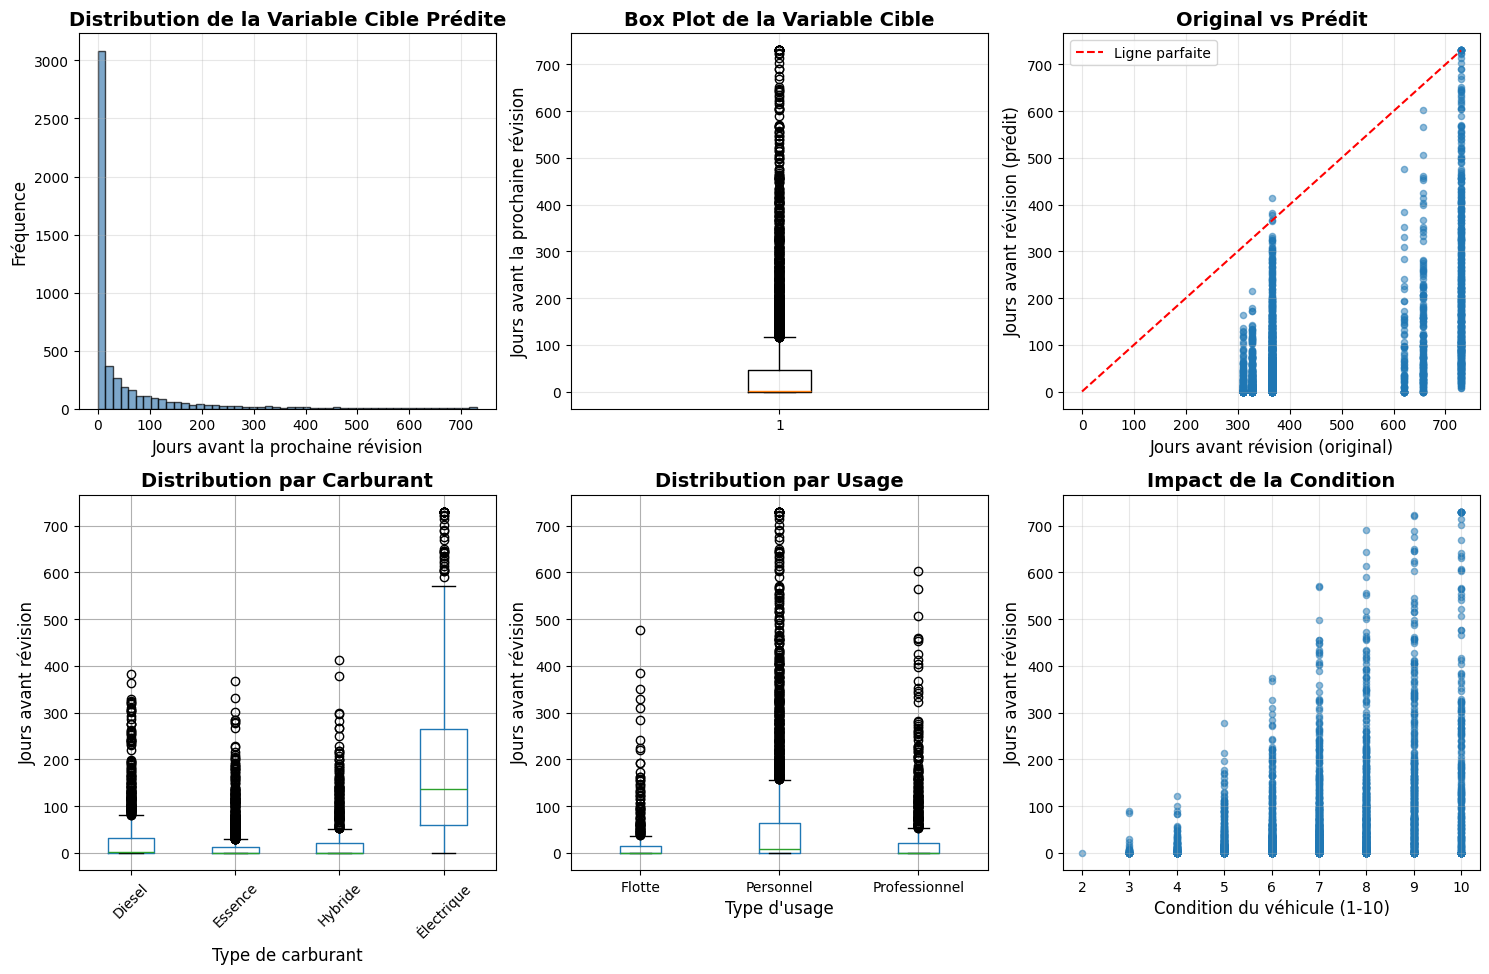

In [26]:
# Création de la variable cible : "Jours avant la prochaine panne"
# Logique : Plus le véhicule est bien entretenu, plus le délai est long

np.random.seed(42)
base_days = df['intervalle_recommande_jours']

# Encodage des variables catégorielles pour les facteurs
carburant_map = {'Essence': 1.0, 'Diesel': 1.1, 'Hybride': 1.2, 'Électrique': 1.5}
df['Carburant_Factor'] = df['carburant'].map(carburant_map)

usage_map = {'Personnel': 1.2, 'Professionnel': 0.9, 'Flotte': 0.8}
df['Usage_Factor'] = df['usage'].map(usage_map)


# Facteurs qui influencent le délai
age_factor = 1 - (df['annee_circulation'].apply(lambda x: 2024 - x) / 15)  # Normalisation sur 15 ans
age_factor = age_factor.clip(0.3, 1.0)  # Éviter les valeurs trop faibles

km_factor = 1 - (df['km_depuis_derniere_revision'] / df['intervalle_recommande_km'])
km_factor = km_factor.clip(0, 1.2)

jours_factor = 1 - (df['jours_depuis_derniere_revision'] / df['intervalle_recommande_jours'])
jours_factor = jours_factor.clip(0, 1.2)

condition_factor = df['condition_vehicule'] / 10  # Normalisation sur 10

pannes_factor = 1 - (df['nb_pannes_historique'] / 5)  # Plus de pannes = moins de délai
pannes_factor = pannes_factor.clip(0.4, 1.0)

revisions_factor = 1 + (df['nb_revisions_effectuees'] / 20)  # Plus de révisions = meilleur entretien
revisions_factor = revisions_factor.clip(1.0, 1.3)

# Calcul du délai avec du bruit aléatoire
df['jours_avant_prochaine_revision_predicted'] = (
    base_days *
    df['Carburant_Factor'] *
    df['Usage_Factor'] *
    age_factor *
    km_factor *
    jours_factor *
    condition_factor *
    pannes_factor *
    revisions_factor *
    np.random.uniform(0.85, 1.15, len(df))
).clip(0, 730)  # Entre 0 jours et 2 ans

print("\nStatistiques de la variable cible :")
print(df['jours_avant_prochaine_revision_predicted'].describe())

# Visualisation de la distribution
plt.figure(figsize=(15, 10))

# Distribution de la variable cible prédite
plt.subplot(2, 3, 1)
plt.hist(df['jours_avant_prochaine_revision_predicted'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('Jours avant la prochaine révision', fontsize=12)
plt.ylabel('Fréquence', fontsize=12)
plt.title('Distribution de la Variable Cible Prédite', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Box plot
plt.subplot(2, 3, 2)
plt.boxplot(df['jours_avant_prochaine_revision_predicted'], vert=True)
plt.ylabel('Jours avant la prochaine révision', fontsize=12)
plt.title('Box Plot de la Variable Cible', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Comparaison original vs prédit
plt.subplot(2, 3, 3)
plt.scatter(df['intervalle_recommande_jours'], # Changed from 'jours_avant_prochaine_revision'
            df['jours_avant_prochaine_revision_predicted'],
            alpha=0.5, s=20)
plt.plot([0, 730], [0, 730], 'r--', label='Ligne parfaite')
plt.xlabel('Jours avant révision (original)', fontsize=12)
plt.ylabel('Jours avant révision (prédit)', fontsize=12)
plt.title('Original vs Prédit', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Distribution par carburant
plt.subplot(2, 3, 4)
df.boxplot(column='jours_avant_prochaine_revision_predicted', by='carburant', ax=plt.gca())
plt.xlabel('Type de carburant', fontsize=12)
plt.ylabel('Jours avant révision', fontsize=12)
plt.title('Distribution par Carburant', fontsize=14, fontweight='bold')
plt.suptitle('')
plt.xticks(rotation=45)

# Distribution par usage
plt.subplot(2, 3, 5)
df.boxplot(column='jours_avant_prochaine_revision_predicted', by='usage', ax=plt.gca())
plt.xlabel('Type d\'usage', fontsize=12)
plt.ylabel('Jours avant révision', fontsize=12)
plt.title('Distribution par Usage', fontsize=14, fontweight='bold')
plt.suptitle('')

# Relation avec condition véhicule
plt.subplot(2, 3, 6)
plt.scatter(df['condition_vehicule'], df['jours_avant_prochaine_revision_predicted'], alpha=0.5, s=20)
plt.xlabel('Condition du véhicule (1-10)', fontsize=12)
plt.ylabel('Jours avant révision', fontsize=12)
plt.title('Impact de la Condition', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Préparation des Données

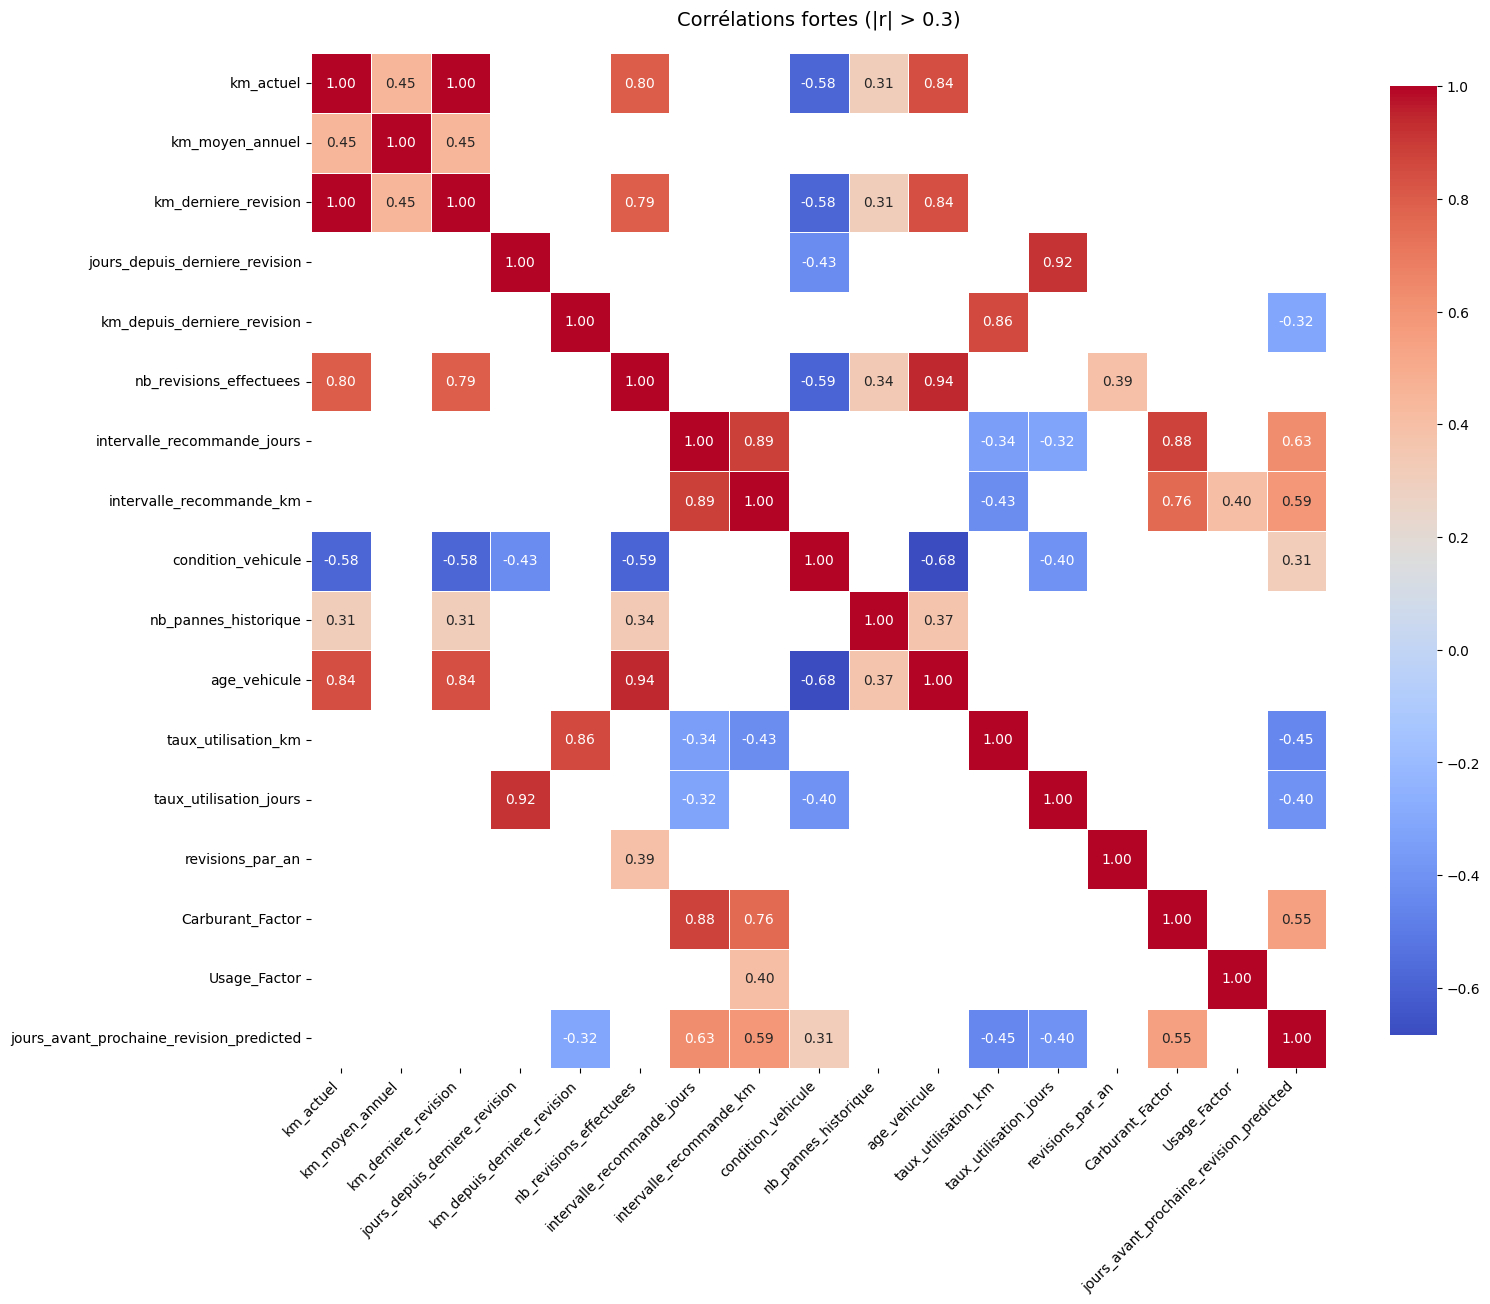

In [27]:
numerical_features = [
    'km_actuel', 'km_moyen_annuel', 'km_derniere_revision',
    'jours_depuis_derniere_revision', 'km_depuis_derniere_revision',
    'nb_revisions_effectuees', 'intervalle_recommande_jours',
    'intervalle_recommande_km', 'condition_vehicule', 'nb_pannes_historique',
    'age_vehicule', 'taux_utilisation_km', 'taux_utilisation_jours',
    'revisions_par_an', 'Carburant_Factor', 'Usage_Factor'
]
plt.figure(figsize=(16, 14))
corr_matrix = df[numerical_features + ['jours_avant_prochaine_revision_predicted']].corr()
# Masquer les corrélations faibles (< 0.3 en valeur absolue)
mask_weak = np.abs(corr_matrix) < 0.3
sns.heatmap(corr_matrix,
            mask=mask_weak,
            annot=True,
            cmap='coolwarm',
            fmt='.2f',
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title('Corrélations fortes (|r| > 0.3)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

In [28]:
# Sélection des variables numériques
numerical_features = [
    'km_actuel', 'km_moyen_annuel', 'km_derniere_revision',
    'jours_depuis_derniere_revision', 'km_depuis_derniere_revision',
    'nb_revisions_effectuees', 'intervalle_recommande_jours',
    'intervalle_recommande_km', 'condition_vehicule', 'nb_pannes_historique',
    'age_vehicule', 'taux_utilisation_km', 'taux_utilisation_jours',
    'revisions_par_an', 'Carburant_Factor', 'Usage_Factor'
]

# Vérification de la disponibilité des colonnes
missing_cols = [col for col in numerical_features if col not in df.columns]
if missing_cols:
    print(f"\n Colonnes manquantes : {missing_cols}")
    print("Colonnes disponibles dans le dataset :")
    print(df.columns.tolist())
else:
    print("\n Toutes les colonnes sont disponibles !")


 Toutes les colonnes sont disponibles !


jours_avant_prochaine_revision_predicted    1.000000
intervalle_recommande_jours                 0.627616
intervalle_recommande_km                    0.588179
Carburant_Factor                            0.549498
condition_vehicule                          0.313905
Usage_Factor                                0.157081
revisions_par_an                            0.013480
km_moyen_annuel                             0.003693
nb_pannes_historique                       -0.131950
km_derniere_revision                       -0.186900
km_actuel                                  -0.207540
nb_revisions_effectuees                    -0.221299
age_vehicule                               -0.245399
jours_depuis_derniere_revision             -0.245670
km_depuis_derniere_revision                -0.315258
taux_utilisation_jours                     -0.403606
taux_utilisation_km                        -0.452981
Name: jours_avant_prochaine_revision_predicted, dtype: float64


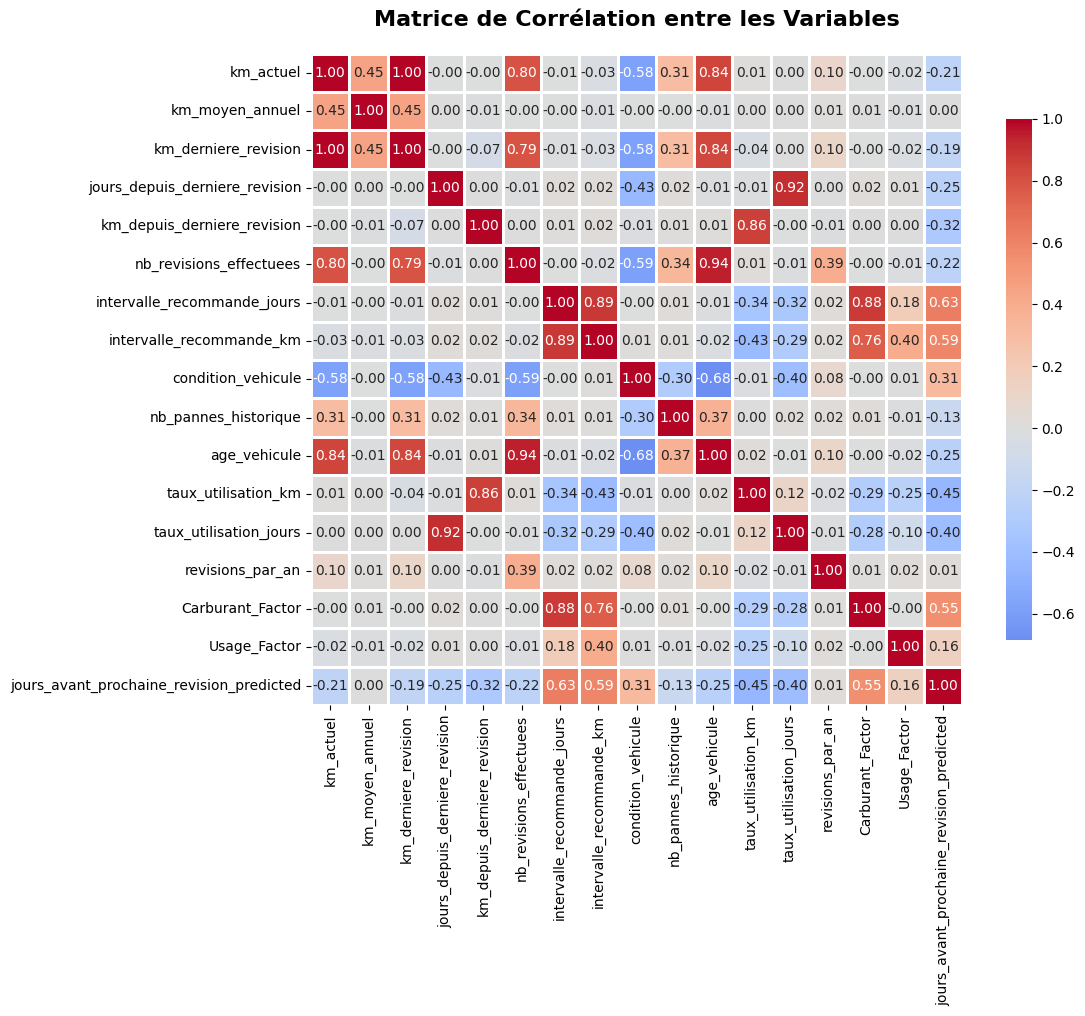


 Variable la plus corrélée : intervalle_recommande_jours (r = 0.6276)


In [29]:
# Analyse de corrélation
correlations = df[numerical_features + ['jours_avant_prochaine_revision_predicted']].corr()['jours_avant_prochaine_revision_predicted'].sort_values(ascending=False)
print(correlations)

# Visualisation de la matrice de corrélation
plt.figure(figsize=(12, 10))
correlation_matrix = df[numerical_features + ['jours_avant_prochaine_revision_predicted']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f',
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matrice de Corrélation entre les Variables', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Identifier la variable la plus corrélée
best_feature = correlations[correlations.index != 'jours_avant_prochaine_revision_predicted'].abs().idxmax()
print(f"\n Variable la plus corrélée : {best_feature} (r = {correlations[best_feature]:.4f})")

# Tester toute les algos + les saves dans un csv

In [30]:
X_multiple = df[numerical_features].values
y = df['jours_avant_prochaine_revision_predicted'].values

In [31]:
results_df, models, scaler = test_regression_algorithms(
        X_multiple, y,
        test_size=0.2,
        random_state=42,
        cv=5,
        scale_data=True,
        use_xgboost=True
)

results_df.to_csv('/content/drive/MyDrive/CMV-IA/results_regression.csv', index=False)


ÉVALUATION DES ALGORITHMES DE RÉGRESSION

Taille du dataset: 5000 échantillons
Nombre de features: 16
Train set: 4000 | Test set: 1000
Validation croisée: 5 folds

--------------------------------------------------------------------------------

Linear Regression:
  Train RMSE: 53.2371 | Test RMSE: 52.3254
  Train MAE:  35.5893 | Test MAE:  34.5733
  Train R²:   0.7221 | Test R²:   0.7047
  CV RMSE:    53.5259 (±2.0784)

Ridge:
  Train RMSE: 53.2561 | Test RMSE: 52.3061
  Train MAE:  35.5343 | Test MAE:  34.5291
  Train R²:   0.7219 | Test R²:   0.7049
  CV RMSE:    53.5475 (±2.0711)

Lasso:
  Train RMSE: 55.3986 | Test RMSE: 54.3848
  Train MAE:  35.8606 | Test MAE:  34.9153
  Train R²:   0.6991 | Test R²:   0.6810
  CV RMSE:    55.6565 (±2.4150)

ElasticNet:
  Train RMSE: 64.5722 | Test RMSE: 62.7811
  Train MAE:  39.0336 | Test MAE:  37.8298
  Train R²:   0.5912 | Test R²:   0.5749
  CV RMSE:    64.7657 (±3.3218)

Decision Tree:
  Train RMSE: 0.0000 | Test RMSE: 32.3678
  Train MAE:

# Régression Linéaire

In [32]:
from xgboost import XGBRegressor
# Préparation des données
X_multiple = df[numerical_features].values
y = df['jours_avant_prochaine_revision_predicted'].values

X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multiple, y, test_size=0.2, random_state=42
)

print(f"\n Taille des ensembles :")
print(f"  • Entraînement : {len(X_train_multi)} exemples × {len(numerical_features)} variables")
print(f"  • Test : {len(X_test_multi)} exemples × {len(numerical_features)} variables")

# Normalisation (importante pour comparer les coefficients)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_multi)
X_test_scaled = scaler.transform(X_test_multi)

print("\n Données normalisées (moyenne=0, écart-type=1)")

# Entraânement du modèle multiple
model_multiple = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model_multiple.fit(X_train_scaled, y_train_multi)

# Prédictions
y_pred_multi = model_multiple.predict(X_test_scaled)


 Taille des ensembles :
  • Entraînement : 4000 exemples × 16 variables
  • Test : 1000 exemples × 16 variables

 Données normalisées (moyenne=0, écart-type=1)


In [33]:
# Création d'un DataFrame pour les coefficients
coef_df = pd.DataFrame({
    'Variable': numerical_features,
    'Importance': model_multiple.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n Importance des variables (triées) :")
print("\n" + coef_df.to_string(index=False))
print("Une importance plus grande = plus d'impact sur la prédiction (contribution à la réduction de l'erreur).")


 Importance des variables (triées) :

                      Variable  Importance
   intervalle_recommande_jours    0.524606
            condition_vehicule    0.189319
                  age_vehicule    0.104561
           taux_utilisation_km    0.061392
        taux_utilisation_jours    0.047199
   km_depuis_derniere_revision    0.019145
          nb_pannes_historique    0.018794
       nb_revisions_effectuees    0.011195
jours_depuis_derniere_revision    0.009967
              revisions_par_an    0.004662
              Carburant_Factor    0.002778
                     km_actuel    0.002672
          km_derniere_revision    0.001786
      intervalle_recommande_km    0.000961
               km_moyen_annuel    0.000578
                  Usage_Factor    0.000385
Une importance plus grande = plus d'impact sur la prédiction (contribution à la réduction de l'erreur).


In [34]:
# Métriques du modèle multiple
r2_multi = r2_score(y_test_multi, y_pred_multi)
mse_multi = mean_squared_error(y_test_multi, y_pred_multi)
rmse_multi = np.sqrt(mse_multi)
mae_multi = mean_absolute_error(y_test_multi, y_pred_multi)

# Comparaison des modèles
comparison_df = pd.DataFrame({
    'Métrique': ['R²', 'RMSE (jours)', 'MAE (jours)'],
    'Modèle Multiple': [r2_multi, rmse_multi, mae_multi],
}).round(4)

print("\n" + comparison_df.to_string(index=False))


    Métrique  Modèle Multiple
          R²           0.9749
RMSE (jours)          15.2565
 MAE (jours)           6.3855


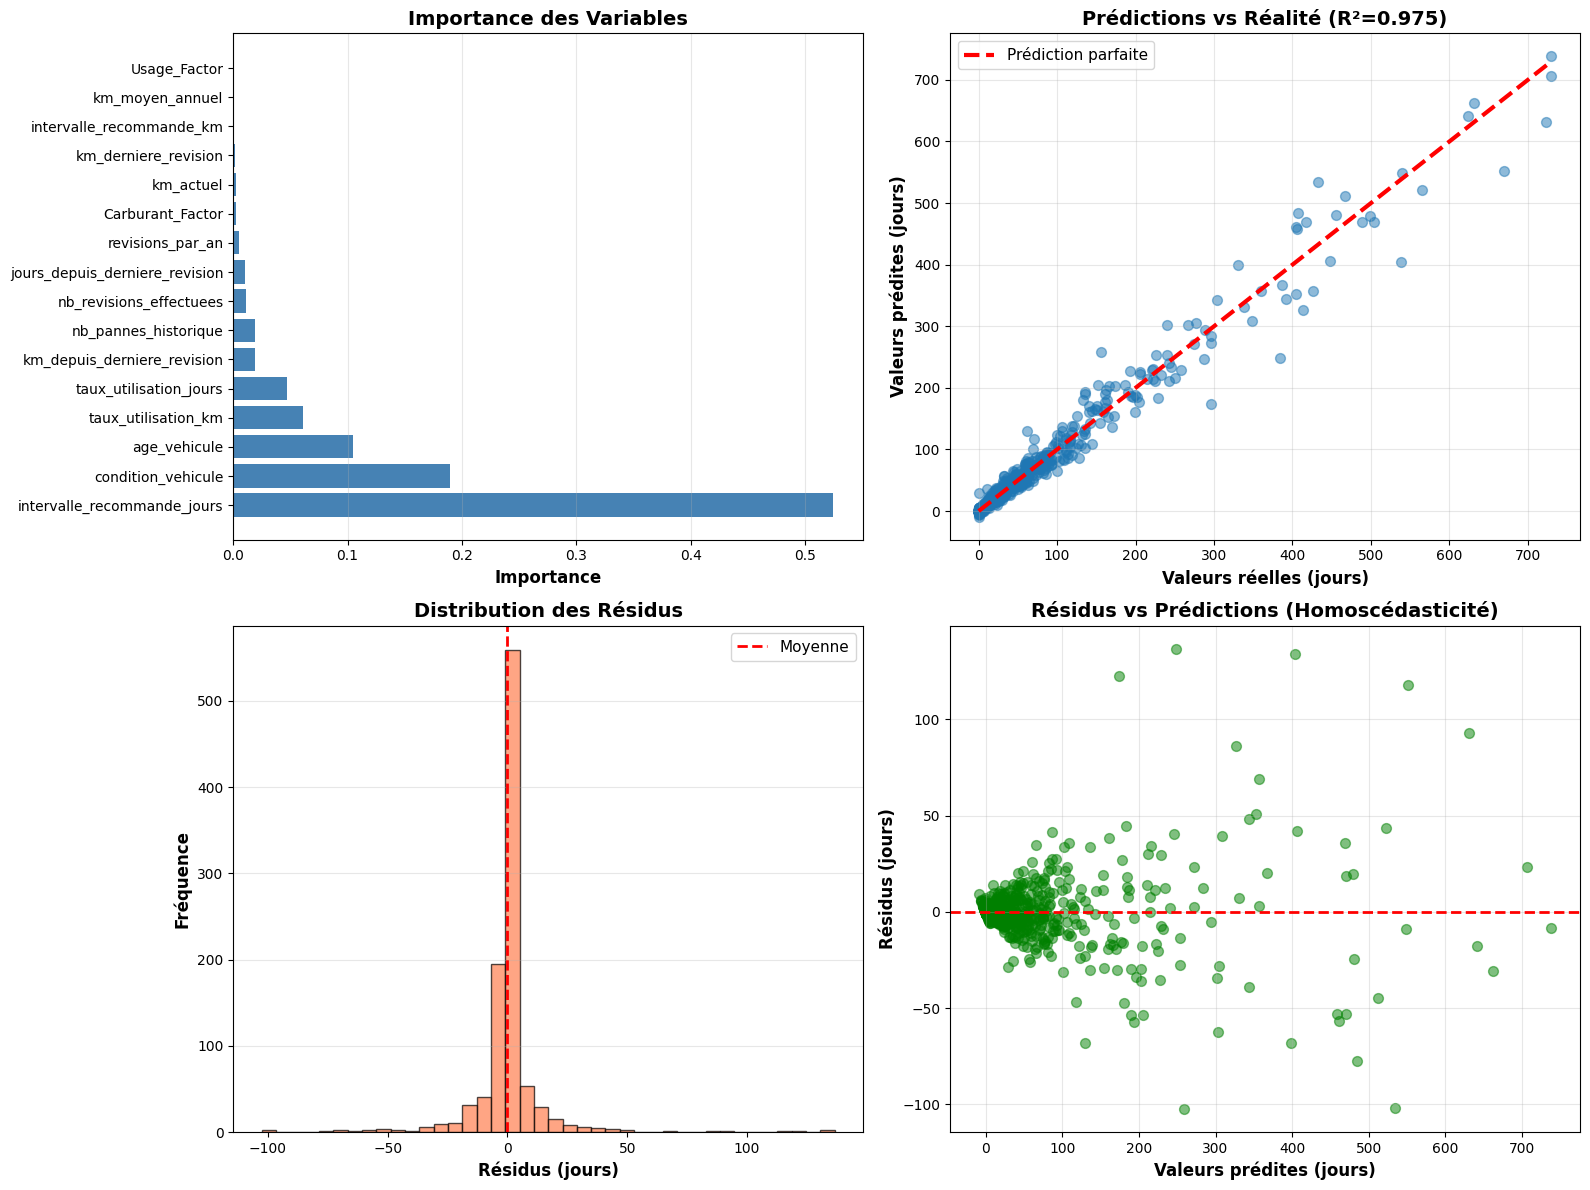


 Analyse des graphiques :
  • Si les résidus sont centrés autour de 0 → Bon signe ✅
  • Si les résidus suivent une distribution normale → Hypothèse respectée ✅
  • Si pas de pattern dans résidus vs prédictions → Homoscédasticité respectée ✅


In [35]:
# Visualisations du modèle multiple
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Graphique 1 : Importance des variables
axes[0, 0].barh(coef_df['Variable'], coef_df['Importance'], color='steelblue')
axes[0, 0].set_xlabel('Importance', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Importance des Variables', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='x')

# Graphique 2 : Prédictions vs Réalité
axes[0, 1].scatter(y_test_multi, y_pred_multi, alpha=0.5, s=50)
axes[0, 1].plot([y_test_multi.min(), y_test_multi.max()],
                [y_test_multi.min(), y_test_multi.max()],
                'r--', linewidth=3, label='Prédiction parfaite')
axes[0, 1].set_xlabel('Valeurs réelles (jours)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Valeurs prédites (jours)', fontsize=12, fontweight='bold')
axes[0, 1].set_title(f'Prédictions vs Réalité (R²={r2_multi:.3f})', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Graphique 3 : Distribution des résidus
residuals = y_test_multi - y_pred_multi
axes[1, 0].hist(residuals, bins=40, edgecolor='black', alpha=0.7, color='coral')
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Moyenne')
axes[1, 0].set_xlabel('Résidus (jours)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Fréquence', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Distribution des Résidus', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Graphique 4 : Résidus vs Prédictions
axes[1, 1].scatter(y_pred_multi, residuals, alpha=0.5, s=50, color='green')
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Valeurs prédites (jours)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Résidus (jours)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Résidus vs Prédictions (Homoscédasticité)', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n Analyse des graphiques :")
print("  • Si les résidus sont centrés autour de 0 → Bon signe ✅")
print("  • Si les résidus suivent une distribution normale → Hypothèse respectée ✅")
print("  • Si pas de pattern dans résidus vs prédictions → Homoscédasticité respectée ✅")

# Prédiction

In [36]:
# Fonction de prédiction
def predict_maintenance(km_actuel, km_moyen_annuel, km_derniere_revision,
                       jours_depuis_derniere_revision, km_depuis_derniere_revision,
                       nb_revisions_effectuees, intervalle_recommande_jours,
                       intervalle_recommande_km, condition_vehicule, nb_pannes_historique,
                       age_vehicule, taux_utilisation_km, taux_utilisation_jours,
                       revisions_par_an, Carburant_Factor, Usage_Factor):
    """
    Prédit le nombre de jours avant la prochaine panne et fournit une recommandation.
    """
    # Créer le DataFrame
    new_vehicle = pd.DataFrame({
        'km_actuel': [km_actuel],
        'km_moyen_annuel': [km_moyen_annuel],
        'km_derniere_revision': [km_derniere_revision],
        'jours_depuis_derniere_revision': [jours_depuis_derniere_revision],
        'km_depuis_derniere_revision': [km_depuis_derniere_revision],
        'nb_revisions_effectuees': [nb_revisions_effectuees],
        'intervalle_recommande_jours': [intervalle_recommande_jours],
        'intervalle_recommande_km': [intervalle_recommande_km],
        'condition_vehicule': [condition_vehicule],
        'nb_pannes_historique': [nb_pannes_historique],
        'age_vehicule': [age_vehicule],
        'taux_utilisation_km': [taux_utilisation_km],
        'taux_utilisation_jours': [taux_utilisation_jours],
        'revisions_par_an': [revisions_par_an],
        'Carburant_Factor': [Carburant_Factor],
        'Usage_Factor': [Usage_Factor]
    })

    # Normaliser et prédire
    new_scaled = scaler.transform(new_vehicle)
    days = model_multiple.predict(new_scaled)[0]

    # Calcul de l'intervalle
    lower_bound = max(0, days - 2 * rmse_multi)
    upper_bound = days + 2 * rmse_multi

    # Formatage de la sortie
    print("="*60)
    print("✓ Estimation : Dans environ {:.1f} mois ({:.0f} jours)".format(days/30, days))
    print("✓ Fourchette : Entre {:.1f} mois et {:.1f} mois".format(lower_bound/30, upper_bound/30))

    # Logique de recommandation simple basée sur l'estimation
    if days < 60:
        recommendation = "Planifier la maintenance très prochainement (< 2 mois)"
    elif days < 150:
        recommendation = "Planifier la maintenance dans les 2 à 5 mois"
    elif days < 270:
         recommendation = "Planifier la maintenance dans 5 à 9 mois"
    else:
        recommendation = "La maintenance n'est pas urgente (> 9 mois)"

    print(f"✓ Recommandation : {recommendation}")
    print("="*60)

    return days

# Exemple
predict_maintenance(
    km_actuel=100000,
    km_moyen_annuel=15000,
    km_derniere_revision=95000,
    jours_depuis_derniere_revision=150,
    km_depuis_derniere_revision=5000,
    nb_revisions_effectuees=10,
    intervalle_recommande_jours=365,
    intervalle_recommande_km=10000,
    condition_vehicule=8,
    nb_pannes_historique=1,
    age_vehicule=7,
    taux_utilisation_km=1.2,
    taux_utilisation_jours=1.0,
    revisions_par_an=1.5,
    Carburant_Factor=1.0,
    Usage_Factor=1.2
)

✓ Estimation : Dans environ 5.9 mois (177 jours)
✓ Fourchette : Entre 4.9 mois et 6.9 mois
✓ Recommandation : Planifier la maintenance dans 5 à 9 mois


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


np.float32(177.00594)

# Export to API

In [ ]:
import pickle

# Dictionnaire contenant le modèle, le scaler et le RMSE
model_data = {
    'model': model_multiple,   
    'scaler': scaler,          
    'rmse': rmse_multi         
}

# Sauvegarde dans le Drive
with open('chemein du model pour l\'export', 'wb') as f:
    pickle.dump(model_data, f)